# Python Active Learning

[PCLAL](https://a24lorie@bitbucket.org/alorieuni/trab_fin_master.git) has resources for active learning in python.

## Active Learning: Definition and Concepts

The main hypothesis in active learning is that if a learning algorithm can choose the data it wants to learn from,
it can perform better than traditional methods with substantially less data for training.

But what are these traditional methods exactly?

## Scenarios

In active learning, there are typically three scenarios or settings in which the learner will query the labels of
instances. The three main scenarios that have been considered in the literature are:

<!---
1. **Stream-Based Selective Sampling**: In this setting, you make the assumption that getting an unlabelled instance is free.
Based on this assumption, you then select each unlabelled instance one at a time and allow the learner to determine
whether it wants to query the label of the instance or reject it based on its informativeness.
To determine informativeness of the the instance, you use a query strategy (see next section).
Following with the example above, you would select one image from the set of unlabelled images, determine whether it
needs to be labelled or discarded, and then repeat with the next imagine.

![MembershipQuery](../static/streamBaseSelectiveSampling.png)
-->

- **Pool-Based sampling**: this setting assumes that there is a large pool of unlabelled data,
as with the stream-based selective sampling. Instances are then drawn from the pool according to some informativeness
measure. This measure is applied to all instances in the pool (or some subset if the pool is very large) and then
the most informative instance(s) are selected. This is the most common scenario in the active learning community.
Continuing with the example in the above two scenarios, all the unlabelled images of digits will be ranked
and then the best (most informative) instance(s) will be selected and their labels requested.

![MembershipQuery](../static/poolBasedSampling.png)

<!---
3. **Membership Query Synthesis**: this is a big term which simply means that the learner generates/constructs an instance
(from some underlying natural distribution). For example, if the data is pictures of digits, the learner would create
an image that is similar to a digit (it might be rotated or some piece of the digit excluded) and this created image
is sent to the oracle to label.)

![MembershipQuery](../static/membershipQuery.png)
-->

## Query Strategies

The main or core difference between an active and a passive learner is the ability to query instances based upon past queries and
the responses (labels) from those queries. As you have read before, all active learning scenarios require some sort of
informativeness measure of the unlabelled instances. In this section I will explain three popular approaches for querying
instances under the common topic called uncertainty sampling due to its use of probabilities
(for more query strategies and more in-depth information on active learning in general I recommend this [survey](http://burrsettles.com/pub/settles.activelearning.pdf)
paper).

- **Random Query**:

- **Entropy Sampling**: in order to utilize all the possible label probabilities, you use a popular measure called entropy.
The entropy formula is applied to each instance and the instance with the largest value is queried.
Using our example, d1 has a value of 0.155 while d2's value is 0.447 and so the learner will select d2 once again.

- **Least Confidence (LC)**: in this strategy, the learner selects the instance for which it has the least confidence in its most likely label.
Looking at the table, the leaner is pretty confident about the label for d1, since it thinks it should be labelled A with probability 0.9,
however, it is less sure about the label of d2 since its probabilities are more spread and it thinks that it should be labelled B with a
probability of only 0.5. Thus, using least confidence, the learner would select d2 to query it's actual label.

- **Margin Sampling**: the shortcoming of the LC strategy, is that it only takes into consideration the most probable label and disregards the other label probabilities. The margin sampling strategy seeks to overcome this disadvantage by selecting the instance that has the smallest difference between the first and second most probable labels. Looking at d1, the difference between its first and second most probable labels is 0.81 (0.9 - 0.09) and for d2 it is 0.2 (0.5 - 0.3). Hence, the leaner will select d2 again.

- **Distance to Boundary Sampling**


## Stopping criteria

- **Max Iterations**:

- **Cost Limit**:

- **Percent Of Unlabel**:

- **Unlabel Set Empty**:

- **TimeLimit**:


## Example

Lets show practical example of active learning.

The Home Equity dataset (HMEQ). This dataset contains a baseline and loan performance information for 5,960 recent home equity loans.
The target (BAD) is a binary variable indicating whether an applicant eventually defaulted or was seriously delinquent.
This adverse outcome occurred in 1,189 cases (20%). For each applicant, 12 input variables were recorded.

First lets load the data

```
df=pd.read_csv('../data/hmeq.csv')

print("Lest look at the shape of the dataset: %s" % str(df.shape))

print("Show first 5 elements")
df.head(5)
```

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, precision_score, recall_score

from dpyacl.strategies.single_label import QueryMarginSampling
from dpyacl.core.stop_criteria import MaxIteration
from dpyacl.experiment import ExperimentAnalyserFactory
from dpyacl.experiment.context import HoldOutExperiment
from dpyacl.metrics import Accuracy, F1, Precision, Recall
from dpyacl.oracle import SimulatedOracle
from dpyacl.scenario.scenario import PoolBasedSamplingScenario
from dpyacl.core.misc import split

df=pd.read_csv('../resources/data/hmeq.csv') #import the dataset

print("Lest look at the shape of the dataset: %s" % str(df.shape))

print("Show first 5 elements")
df.head(5)

Lest look at the shape of the dataset: (5960, 13)
Show first 5 elements


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [29]:
from dask.distributed import Client

client = Client("tcp://192.168.2.100:8786")
client

Client Scheduler: tcp://192.168.2.100:8786 Dashboard: http://192.168.2.100:8787/status,Cluster Workers: 7 Cores: 14 Memory: 21.00 GB


Lets check for missing Values

```
missing=df.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values') # the isnull() returns 1 if the value is null
missing
```

In [30]:
missing=df.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values') # the isnull() returns 1 if the value is null
missing

,Variables,Missing Values
0,BAD,0
1,LOAN,0
2,MORTDUE,518
3,VALUE,112
4,REASON,252
5,JOB,279
6,YOJ,515
7,DEROG,708
8,DELINQ,580
9,CLAGE,308


Dropping missing Values

```
df.dropna(axis=0, how='any', inplace=True)
print("Lest look at the shape of the dataset: %s" % str(df.shape))

noMissing=df.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values') # the isnull() returns 1 if the value is null
noMissing
```

In [31]:
df.dropna(axis=0, how='any', inplace=True)

print("Lest look at the shape of the dataset: %s" % str(df.shape))

noMissing=df.isnull().sum().rename_axis('Variables').reset_index(name='Missing Values') # the isnull() returns 1 if the value is null
noMissing

Lest look at the shape of the dataset: (3364, 13)


,Variables,Missing Values
0,BAD,0
1,LOAN,0
2,MORTDUE,0
3,VALUE,0
4,REASON,0
5,JOB,0
6,YOJ,0
7,DEROG,0
8,DELINQ,0
9,CLAGE,0


Analyzing the distribution of the target variable BAD

```
df["BAD"].value_counts().plot.bar(title='BAD')
```

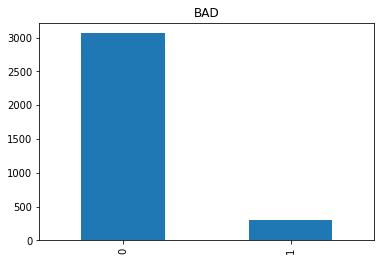

In [32]:
#Frequency distribution of target variable "BAD" and visualizing the target variable
df["BAD"].value_counts().plot.bar(title='BAD')

Correlation Analysis

```
#Create Correlation matrix
corr = df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10,8))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()
```

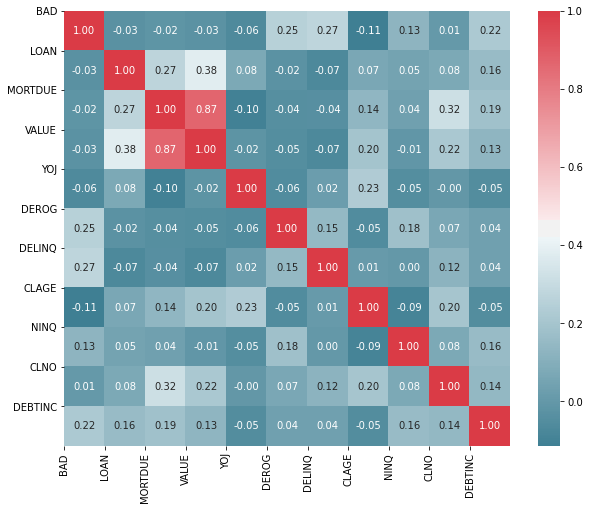

In [33]:
#Create Correlation matrix
corr = df.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10,8))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()


Encoding

As many of the Machine Learning models takes only the numerical values as input so we have to convert categorical columns
to numeric Dummy variable turns categorical variables into a series of 0 and 1, making them much easier to compare

```
df=pd.get_dummies(df, columns=['REASON','JOB'])

print("Show first 5 elements")
df.head(5)
```

In [34]:
df=pd.get_dummies(df, columns=['REASON','JOB'])

print("Show first 5 elements")
df.head(5)

Show first 5 elements


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
5,1,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,0,1,0,0,1,0,0,0
7,1,1800,28502.0,43034.0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,0,1,0,0,1,0,0,0
19,0,2300,102370.0,120953.0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,0,1,0,1,0,0,0,0
25,1,2400,34863.0,47471.0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,0,1,1,0,0,0,0,0
26,0,2400,98449.0,117195.0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,0,1,0,1,0,0,0,0


Extract independent and target variables and partition datasets

```
X = df.drop(['BAD'], axis=1)
y = df.filter(['BAD'], axis=1)

train_idx, test_idx, label_idx, unlabel_idx = split(
    X=X,
    y=y['BAD'],
    test_ratio=0.3,
    initial_label_rate=0.05,
    split_count=1,
    all_class=True)
```

In [35]:
X = df.drop(['BAD'], axis=1)
y = df.filter(['BAD'], axis=1)

print("Show first 5 elements of X")
X.head(5)

print("Show first 5 elements of y")
y.head(5)


train_idx, test_idx, label_idx, unlabel_idx = split(
    X=X,
    y=y['BAD'],
    test_ratio=0.3,
    initial_label_rate=0.05,
    split_count=1,
    all_class=True)

Show first 5 elements of X
Show first 5 elements of y


## Now lets prepare the active learning experiment
Define the machine learning technique

```
ml_technique = LogisticRegression(solver='liblinear')
```

In [36]:
ml_technique = LogisticRegression(solver='sag')

Define the stopping criteria
```
stopping_criteria = MaxIteration(50)
```

In [37]:
stopping_criteria = MaxIteration(5)

Define the Query Strategy
```
query_strategy =  QueryMarginSampling()
```

In [38]:
query_strategy =  QueryMarginSampling()

Choose the evaluation Metrics

```
performance_metrics = [ Accuracy(), F1(average='macro'), Precision(average='macro'), Recall(average='macro')]
```

In [39]:
performance_metrics = [
                Accuracy(),
                F1(average='macro'),
                Precision(average='macro'),
                Recall(average='macro')]

Create an experiment with the partitioned data

```
experiment = HoldOutExperiment(
    X,
    y['BAD'],
    train_idx=train_idx,
    test_idx=test_idx,
    label_idx=label_idx,
    unlabel_idx=unlabel_idx,
    ml_technique=ml_technique,
    performance_metrics=performance_metrics,
    query_strategy=query_strategy,
    oracle=SimulatedOracle(labels=y),
    stopping_criteria=stopping_criteria,
    self_partition=False
)
```

In [42]:
%%time
# init the ALExperiment
experiment = HoldOutExperiment(
    client=client,
    X=X.to_numpy(),
    Y=y['BAD'].to_numpy(),
    scenario_type=PoolBasedSamplingScenario,
    train_idx=train_idx,
    test_idx=test_idx,
    label_idx=label_idx,
    unlabel_idx=unlabel_idx,
    ml_technique=ml_technique,
    performance_metrics=performance_metrics,
    query_strategy=query_strategy,
    oracle=SimulatedOracle(labels=y['BAD'].to_numpy()),
    stopping_criteria=stopping_criteria,
    self_partition=False,
    rebalance=True,
    batch_size=50
)

ValueError: During rebalance 1 keys were found to be missing

Execute the experiment

```
result = experiment.evaluate(verbose=True)
```

In [41]:
%%time
result = experiment.evaluate(client=client, verbose=True)

/home/alorie/Documents/WORKSPACES/WorkspaceUIMP/trabajo_fin_master/dpyacl/scenario/scenario.py:91: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  label_pred = self._ml_technique.predict(self._X[self._test_idx, :])
/home/alorie/Documents/WORKSPACES/WorkspaceUIMP/trabajo_fin_master/dpyacl/scenario/scenario.py:100: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  value = delayed(metric.compute(y_true=self._Y[self._test_idx], y_pred=label_pred))
/home/alorie/Documents/WORKSPACES/WorkspaceUIMP/trabajo_fin_master/dpyacl/scenario/scenario.py:100: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  value = delayed(metric.compute(y_true=self._Y[self._test_idx], y_pred=label_pred))
/home/alorie/Documents/WORKSPACES/WorkspaceUIMP/trabajo_fin_master/dpyacl/scenario/scenario.py:100: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Analyse the experiment results

```
query_analyser = ExperimentAnalyserFactory.experiment_analyser(
                    performance_metrics= [metric.metric_name for metric in performance_metrics],
                    method_name=query_strategy.query_function_name,
                    method_results=result,
                    type="queries"
                )

# get a brief description of the experiment
query_analyser.plot_learning_curves(title='Active Learning experiment results')
```

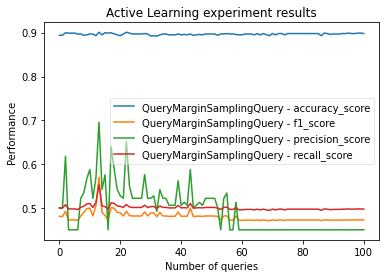

In [18]:
query_analyser = ExperimentAnalyserFactory.experiment_analyser(
                    performance_metrics= [metric.metric_name for metric in performance_metrics],
                    method_name=query_strategy.query_function_name,
                    method_results=result,
                    type="queries"
                )

# get a brief description of the experiment
query_analyser.plot_learning_curves(title='Active Learning experiment results')

Retrieve the generated model and predict over the test dataset

```

foldIndex = 0
train_x = X.iloc[train_idx[foldIndex], :]
train_y = y.iloc[train_idx[foldIndex], :]
test_x = X.iloc[test_idx[foldIndex], :]
test_y = y.iloc[test_idx[foldIndex], :]

active_y_pred = result[0].ml_technique.predict(test_x)

```

In [15]:
foldIndex = 0
train_x = X.iloc[train_idx[foldIndex], :]
train_y = y.iloc[train_idx[foldIndex], :]
test_x = X.iloc[test_idx[foldIndex], :]
test_y = y.iloc[test_idx[foldIndex], :]

active_y_pred = result[0].ml_technique.predict(test_x)

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

Evaluate the predicted scores

```
print("Active Learning Accuracy score : ", accuracy_score(test_y, active_y_pred))
print("Active Learning F1 score: ", f1_score(test_y, active_y_pred, average='macro'))
print("Active Learning Hamming Loss", hamming_loss(test_y, active_y_pred))
print("Active Learning Precision score : ", precision_score(test_y, active_y_pred, average='macro'))
print("Active Learning Recall score : ", recall_score(test_y, active_y_pred, average='macro'))
```

In [ ]:
print("Active Learning Accuracy score : ", accuracy_score(test_y, active_y_pred))
print("Active Learning F1 score: ", f1_score(test_y, active_y_pred, average='macro', zero_division=0))
print("Active Learning Hamming Loss", hamming_loss(test_y, active_y_pred))
print("Active Learning Precision score : ", precision_score(test_y, active_y_pred, average='macro', zero_division=0))
print("Active Learning Recall score : ", recall_score(test_y, active_y_pred, average='macro', zero_division=0))